In [1]:
"""
回归任务：基于20日K线图预测未来收益率
"""
use_gpu = True
use_ramdon_split = False
use_dataparallel = True

# 模型选择: "baseline" | "large"
model_type = "baseline"

# 回归目标: "Ret_20d" (20日收益率) | "Ret_5d" (5日收益率)
target_col = "Ret_5d"

In [2]:
import os
import sys
sys.path.insert(0, '..')

if use_gpu:
    os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1, 2, 3, 4, 5, 6,7"

import time
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split



torch.manual_seed(42)

IMAGE_WIDTH = {5: 15, 20: 60, 60: 180}
IMAGE_HEIGHT = {5: 32, 20: 64, 60: 96}  

## Load Data

回归任务：预测股票未来收益率

- 训练数据: 1993-2000
- 目标变量: Ret_20d (未来20日收益率)

In [3]:
year_list = np.arange(1993,2001,1)

images = []
label_df = []
for year in year_list:
    images.append(np.memmap(os.path.join("../data/monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_images.dat"), dtype=np.uint8, mode='r').reshape(
                        (-1, IMAGE_HEIGHT[20], IMAGE_WIDTH[20])))
    label_df.append(pd.read_feather(os.path.join("../data/monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_labels_w_delay.feather")))
    
images = np.concatenate(images)
label_df = pd.concat(label_df)

print(images.shape)
print(label_df.shape)

(793019, 64, 60)
(793019, 8)


## build dataset

In [4]:
class RegressionDataset(Dataset):
    """
    回归任务数据集
    label: 连续值（收益率）
    """
    def __init__(self, img, label):
        self.img = torch.Tensor(img.copy())
        self.label = torch.Tensor(label).float()  # 确保是 float 类型
        self.len = len(img)
  
    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.img[idx], self.label[idx]

Split method (not random split is recommended)

In [5]:
# 获取回归目标（收益率）
target_values = label_df[target_col].values

# 检查 NaN 值
nan_count = np.isnan(target_values).sum()
print(f"Target: {target_col}")
print(f"  Total samples: {len(target_values)}")
print(f"  NaN count: {nan_count} ({nan_count/len(target_values)*100:.2f}%)")

# 如果有 NaN，需要过滤掉
if nan_count > 0:
    print(f"\n⚠️ Found {nan_count} NaN values, filtering them out...")
    valid_mask = ~np.isnan(target_values)
    target_values = target_values[valid_mask]
    images = images[valid_mask]
    print(f"  After filtering: {len(target_values)} samples")

# 打印目标变量统计信息
print(f"\nTarget statistics:")
print(f"  Mean: {target_values.mean():.6f}")
print(f"  Std:  {target_values.std():.6f}")
print(f"  Min:  {target_values.min():.6f}")
print(f"  Max:  {target_values.max():.6f}")

if not use_ramdon_split:
    train_val_ratio = 0.7
    split_idx = int(images.shape[0] * 0.7)
    train_dataset = RegressionDataset(images[:split_idx], target_values[:split_idx])
    val_dataset = RegressionDataset(images[split_idx:], target_values[split_idx:])
else:
    dataset = RegressionDataset(images, target_values)
    train_val_ratio = 0.7
    train_dataset, val_dataset = random_split(dataset, \
        [int(dataset.len*train_val_ratio), dataset.len-int(dataset.len*train_val_ratio)], \
        generator=torch.Generator().manual_seed(42))
    del dataset

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False, pin_memory=True)

print(f"\nTrain samples: {len(train_dataset)}")
print(f"Val samples:   {len(val_dataset)}")

Target: Ret_5d
  Total samples: 793019
  NaN count: 2228 (0.28%)

⚠️ Found 2228 NaN values, filtering them out...
  After filtering: 790791 samples

Target statistics:
  Mean: 0.006686
  Std:  0.109974
  Min:  -0.925926
  Max:  27.000008

Train samples: 553553
Val samples:   237238


## Regression Model

In [6]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.)
    elif isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)

In [7]:
from models import baseline_regression

device = 'cuda' if use_gpu else 'cpu'
print(f"Using device: {device}")

# 根据 model_type 选择模型
if model_type == "baseline":
    net = baseline_regression.Net().to(device)
elif model_type == "large":
    net = baseline_regression.NetLarge().to(device)
else:
    raise ValueError(f"Unknown model_type: {model_type}")

print(f"Using model: {model_type} (Regression)")
net.apply(init_weights)

# 统计参数量
num_params = sum(p.numel() for p in net.parameters())
print(f"Total parameters: {num_params:,} ({num_params/1e6:.2f}M)")


Using device: cuda
Using model: baseline (Regression)
Total parameters: 24,243,073 (24.24M)


### Model Architecture

In [8]:
# 打印模型结构
print(net)
print("\n" + "="*50)
print("Layer-wise parameters:")
print("="*50)
for name, param in net.named_parameters():
    print(f"{name}: {param.size()}")

Net(
  (layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 3), stride=(3, 1), padding=(12, 1), dilation=(2, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 3), stride=(3, 1), padding=(12, 1), dilation=(2, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 3), stride=(3, 1), padding=(12, 1), dilation=(2, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): MaxPoo

In [9]:
# 测试前向传播
with torch.no_grad():
    sample_input = next(iter(train_dataloader))[0][:4].to(device)
    sample_output = net(sample_input)
    print(f"Input shape: {sample_input.shape}")
    print(f"Output shape: {sample_output.shape}")
    print(f"Sample predictions: {sample_output.cpu().numpy()}")

Input shape: torch.Size([4, 64, 60])
Output shape: torch.Size([4])
Sample predictions: [ 0.17540896 -1.0684863   2.616239   -1.58216   ]


In [10]:
# 删除旧的 profiling 代码，直接进入训练

## Training (Regression)

In [11]:
def train_loop(dataloader, net, loss_fn, optimizer, tb, global_step):
    """
    回归任务训练循环
    Args:
        tb: TensorBoard SummaryWriter
        global_step: 当前全局步数（用于记录 step 级别的 loss）
    Returns:
        running_loss: epoch 平均 MSE loss
        global_step: 更新后的全局步数
    """
    running_loss = 0.0
    current = 0
    net.train()
    
    with tqdm(dataloader) as t:
        for batch, (X, y) in enumerate(t):
            X = X.to(device)
            y = y.to(device).float()  # 回归任务需要 float
            y_pred = net(X)
            loss = loss_fn(y_pred, y)  # 回归 loss（无需 .long()）
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # 每 100 步记录一次 loss
            if global_step % 100 == 0:
                tb.add_scalar("Loss/train_step", loss.item(), global_step)
            global_step += 1

            running_loss = (len(X) * loss.item() + running_loss * current) / (len(X) + current)
            current += len(X)
            t.set_postfix({'mse_loss': f'{running_loss:.6f}'})
    
    return running_loss, global_step

In [12]:
def val_loop(dataloader, net, loss_fn):
    """
    回归任务验证循环
    同时计算 MSE 和 MAE
    """
    running_loss = 0.0
    running_mae = 0.0
    current = 0
    net.eval()
    
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        with tqdm(dataloader, desc="Validation") as t:
            for batch, (X, y) in enumerate(t):
                X = X.to(device)
                y = y.to(device).float()
                y_pred = net(X)
                
                loss = loss_fn(y_pred, y)  # MSE
                mae = torch.abs(y_pred - y).mean()  # MAE
                
                all_preds.append(y_pred.cpu())
                all_targets.append(y.cpu())

                running_loss = (len(X) * loss.item() + running_loss * current) / (len(X) + current)
                running_mae = (len(X) * mae.item() + running_mae * current) / (len(X) + current)
                current += len(X)
                
                t.set_postfix({'mse': f'{running_loss:.6f}', 'mae': f'{running_mae:.6f}'})
    
    # 计算相关系数
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    correlation = torch.corrcoef(torch.stack([all_preds, all_targets]))[0, 1].item()
    
    return running_loss, running_mae, correlation

In [13]:
# net = torch.load('/home/clidg/proj_2/pt/baseline_epoch_10_train_0.6865865240322523_eval_0.686580_.pt')

In [14]:
if use_gpu and use_dataparallel and 'DataParallel' not in str(type(net)):
    net = net.to(device)
    net = nn.DataParallel(net, device_ids=[0, 1, 2, 3, 4, 5, 6, 7])

In [15]:
# 回归任务使用 MSE Loss
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)  # 回归任务可以用稍大的学习率

start_epoch = 0
min_val_loss = 1e9
last_min_ind = -1
early_stopping_epoch = 10  # 回归任务可能需要更多耐心

from torch.utils.tensorboard import SummaryWriter
tb = SummaryWriter(comment=f"_regression_{model_type}")

print(f"Loss function: MSELoss")
print(f"Optimizer: Adam (lr=1e-4)")
print(f"Early stopping patience: {early_stopping_epoch} epochs")

Loss function: MSELoss
Optimizer: Adam (lr=1e-4)
Early stopping patience: 10 epochs


In [16]:
# 创建保存目录
start_time = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
save_dir = f'../pt/regression_{model_type}_{start_time}'
os.makedirs(save_dir, exist_ok=True)
print(f"Save directory: {save_dir}")

epochs = 100
global_step = 0
best_model_path = None

# 记录训练历史
history = {
    'train_loss': [],
    'val_loss': [],
    'val_mae': [],
    'val_corr': []
}

for t in range(start_epoch, epochs):
    print(f"\nEpoch {t}")
    print("-" * 50)
    
    time.sleep(0.1)
    train_loss, global_step = train_loop(train_dataloader, net, loss_fn, optimizer, tb, global_step)
    val_loss, val_mae, val_corr = val_loop(val_dataloader, net, loss_fn)
    
    # 记录历史
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_mae'].append(val_mae)
    history['val_corr'].append(val_corr)
    
    # 记录到 TensorBoard
    tb.add_scalar("Loss/train_mse", train_loss, t)
    tb.add_scalar("Loss/val_mse", val_loss, t)
    tb.add_scalar("Metrics/val_mae", val_mae, t)
    tb.add_scalar("Metrics/val_correlation", val_corr, t)
    
    print(f"  Train MSE: {train_loss:.6f}")
    print(f"  Val MSE:   {val_loss:.6f}")
    print(f"  Val MAE:   {val_mae:.6f}")
    print(f"  Val Corr:  {val_corr:.4f}")
    
    # 保存模型
    model_path = f'{save_dir}/epoch_{t}_mse_{val_loss:.6f}_corr_{val_corr:.4f}.pt'
    torch.save(net, model_path)
    
    if val_loss < min_val_loss:
        last_min_ind = t
        min_val_loss = val_loss
        best_model_path = model_path
        # 保存最佳模型
        torch.save(net, f'{save_dir}/best.pt')
        print(f"  ★ New best model saved!")
    elif t - last_min_ind >= early_stopping_epoch:
        print(f"\nEarly stopping at epoch {t}")
        break

tb.close()
print('\n' + '='*50)
print('Training Complete!')
print('='*50)
print(f'Best epoch: {last_min_ind}')
print(f'Best val MSE: {min_val_loss:.6f}')
print(f'Best model: {best_model_path}')

Save directory: ../pt/regression_baseline_20251203_092752

Epoch 0
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:20<00:00, 45.53it/s, mse=0.017224, mae=0.073513]


  Train MSE: 0.077428
  Val MSE:   0.017224
  Val MAE:   0.073513
  Val Corr:  0.0226
  ★ New best model saved!

Epoch 1
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:19<00:00, 48.74it/s, mse=0.017203, mae=0.074125]


  Train MSE: 0.010271
  Val MSE:   0.017203
  Val MAE:   0.074125
  Val Corr:  0.0418
  ★ New best model saved!

Epoch 2
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:18<00:00, 49.04it/s, mse=0.017239, mae=0.073220]


  Train MSE: 0.010048
  Val MSE:   0.017239
  Val MAE:   0.073220
  Val Corr:  0.0425

Epoch 3
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:18<00:00, 48.84it/s, mse=0.017194, mae=0.073663]


  Train MSE: 0.009934
  Val MSE:   0.017194
  Val MAE:   0.073663
  Val Corr:  0.0625
  ★ New best model saved!

Epoch 4
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:18<00:00, 49.25it/s, mse=0.017203, mae=0.073623]


  Train MSE: 0.010012
  Val MSE:   0.017203
  Val MAE:   0.073623
  Val Corr:  0.0634

Epoch 5
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:19<00:00, 48.72it/s, mse=0.017216, mae=0.072984]


  Train MSE: 0.009923
  Val MSE:   0.017216
  Val MAE:   0.072984
  Val Corr:  0.0725

Epoch 6
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:18<00:00, 49.69it/s, mse=0.017119, mae=0.073318]


  Train MSE: 0.009808
  Val MSE:   0.017119
  Val MAE:   0.073318
  Val Corr:  0.0959
  ★ New best model saved!

Epoch 7
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:18<00:00, 49.11it/s, mse=0.017038, mae=0.073084]


  Train MSE: 0.009757
  Val MSE:   0.017038
  Val MAE:   0.073084
  Val Corr:  0.1159
  ★ New best model saved!

Epoch 8
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:19<00:00, 48.18it/s, mse=0.017009, mae=0.072940]


  Train MSE: 0.009700
  Val MSE:   0.017009
  Val MAE:   0.072940
  Val Corr:  0.1261
  ★ New best model saved!

Epoch 9
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:19<00:00, 48.75it/s, mse=0.016958, mae=0.073814]


  Train MSE: 0.009665
  Val MSE:   0.016958
  Val MAE:   0.073814
  Val Corr:  0.1299
  ★ New best model saved!

Epoch 10
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:19<00:00, 48.52it/s, mse=0.016954, mae=0.073087]


  Train MSE: 0.009642
  Val MSE:   0.016954
  Val MAE:   0.073087
  Val Corr:  0.1316
  ★ New best model saved!

Epoch 11
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:18<00:00, 49.34it/s, mse=0.017003, mae=0.073185]


  Train MSE: 0.009399
  Val MSE:   0.017003
  Val MAE:   0.073185
  Val Corr:  0.1271

Epoch 12
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:18<00:00, 49.28it/s, mse=0.017134, mae=0.072995]


  Train MSE: 0.009009
  Val MSE:   0.017134
  Val MAE:   0.072995
  Val Corr:  0.1038

Epoch 13
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:19<00:00, 48.73it/s, mse=0.016992, mae=0.072762]


  Train MSE: 0.009399
  Val MSE:   0.016992
  Val MAE:   0.072762
  Val Corr:  0.1283

Epoch 14
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:18<00:00, 49.68it/s, mse=0.017000, mae=0.073985]


  Train MSE: 0.009220
  Val MSE:   0.017000
  Val MAE:   0.073985
  Val Corr:  0.1207

Epoch 15
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:18<00:00, 48.90it/s, mse=0.017102, mae=0.072671]


  Train MSE: 0.008953
  Val MSE:   0.017102
  Val MAE:   0.072671
  Val Corr:  0.1192

Epoch 16
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:18<00:00, 48.95it/s, mse=0.017168, mae=0.073204]


  Train MSE: 0.009339
  Val MSE:   0.017168
  Val MAE:   0.073204
  Val Corr:  0.0759

Epoch 17
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:19<00:00, 48.09it/s, mse=0.017060, mae=0.075104]


  Train MSE: 0.009801
  Val MSE:   0.017060
  Val MAE:   0.075104
  Val Corr:  0.1086

Epoch 18
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:19<00:00, 48.46it/s, mse=0.017006, mae=0.073511]


  Train MSE: 0.009731
  Val MSE:   0.017006
  Val MAE:   0.073511
  Val Corr:  0.1198

Epoch 19
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:19<00:00, 48.66it/s, mse=0.016939, mae=0.073810]


  Train MSE: 0.009675
  Val MSE:   0.016939
  Val MAE:   0.073810
  Val Corr:  0.1283
  ★ New best model saved!

Epoch 20
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:19<00:00, 48.65it/s, mse=0.016936, mae=0.072953]


  Train MSE: 0.009640
  Val MSE:   0.016936
  Val MAE:   0.072953
  Val Corr:  0.1358
  ★ New best model saved!

Epoch 21
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:18<00:00, 49.00it/s, mse=0.016974, mae=0.072749]


  Train MSE: 0.009574
  Val MSE:   0.016974
  Val MAE:   0.072749
  Val Corr:  0.1317

Epoch 22
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:18<00:00, 48.89it/s, mse=0.016990, mae=0.073128]


  Train MSE: 0.009658
  Val MSE:   0.016990
  Val MAE:   0.073128
  Val Corr:  0.1231

Epoch 23
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:18<00:00, 48.84it/s, mse=0.017050, mae=0.073409]


  Train MSE: 0.009003
  Val MSE:   0.017050
  Val MAE:   0.073409
  Val Corr:  0.1089

Epoch 24
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:19<00:00, 48.56it/s, mse=0.016979, mae=0.073155]


  Train MSE: 0.008722
  Val MSE:   0.016979
  Val MAE:   0.073155
  Val Corr:  0.1264

Epoch 25
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:18<00:00, 49.11it/s, mse=0.016982, mae=0.073712]


  Train MSE: 0.008524
  Val MSE:   0.016982
  Val MAE:   0.073712
  Val Corr:  0.1224

Epoch 26
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:18<00:00, 48.87it/s, mse=0.016993, mae=0.073358]


  Train MSE: 0.009678
  Val MSE:   0.016993
  Val MAE:   0.073358
  Val Corr:  0.1292

Epoch 27
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:18<00:00, 49.13it/s, mse=0.016934, mae=0.072938]


  Train MSE: 0.009629
  Val MSE:   0.016934
  Val MAE:   0.072938
  Val Corr:  0.1352
  ★ New best model saved!

Epoch 28
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:18<00:00, 49.18it/s, mse=0.016963, mae=0.073212]


  Train MSE: 0.009476
  Val MSE:   0.016963
  Val MAE:   0.073212
  Val Corr:  0.1323

Epoch 29
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:18<00:00, 49.12it/s, mse=0.016980, mae=0.072754]


  Train MSE: 0.009045
  Val MSE:   0.016980
  Val MAE:   0.072754
  Val Corr:  0.1322

Epoch 30
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:19<00:00, 48.19it/s, mse=0.017010, mae=0.072806]


  Train MSE: 0.008434
  Val MSE:   0.017010
  Val MAE:   0.072806
  Val Corr:  0.1252

Epoch 31
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:18<00:00, 49.15it/s, mse=0.016951, mae=0.072668]


  Train MSE: 0.009634
  Val MSE:   0.016951
  Val MAE:   0.072668
  Val Corr:  0.1389

Epoch 32
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:19<00:00, 48.33it/s, mse=0.016948, mae=0.073685]


  Train MSE: 0.009604
  Val MSE:   0.016948
  Val MAE:   0.073685
  Val Corr:  0.1388

Epoch 33
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:19<00:00, 48.15it/s, mse=0.016931, mae=0.073101]


  Train MSE: 0.009519
  Val MSE:   0.016931
  Val MAE:   0.073101
  Val Corr:  0.1356
  ★ New best model saved!

Epoch 34
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:18<00:00, 49.22it/s, mse=0.016947, mae=0.073233]


  Train MSE: 0.008587
  Val MSE:   0.016947
  Val MAE:   0.073233
  Val Corr:  0.1305

Epoch 35
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:18<00:00, 48.94it/s, mse=0.016976, mae=0.072956]


  Train MSE: 0.009495
  Val MSE:   0.016976
  Val MAE:   0.072956
  Val Corr:  0.1269

Epoch 36
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:18<00:00, 49.28it/s, mse=0.016953, mae=0.072943]


  Train MSE: 0.008330
  Val MSE:   0.016953
  Val MAE:   0.072943
  Val Corr:  0.1325

Epoch 37
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:18<00:00, 48.93it/s, mse=0.016903, mae=0.073559]


  Train MSE: 0.009320
  Val MSE:   0.016903
  Val MAE:   0.073559
  Val Corr:  0.1382
  ★ New best model saved!

Epoch 38
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:19<00:00, 48.21it/s, mse=0.017176, mae=0.073081]


  Train MSE: 0.008541
  Val MSE:   0.017176
  Val MAE:   0.073081
  Val Corr:  0.1156

Epoch 39
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:18<00:00, 48.93it/s, mse=0.016975, mae=0.074318]


  Train MSE: 0.009680
  Val MSE:   0.016975
  Val MAE:   0.074318
  Val Corr:  0.1368

Epoch 40
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:20<00:00, 46.35it/s, mse=0.016911, mae=0.072962]


  Train MSE: 0.009610
  Val MSE:   0.016911
  Val MAE:   0.072962
  Val Corr:  0.1397

Epoch 41
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:19<00:00, 48.37it/s, mse=0.016887, mae=0.073177]


  Train MSE: 0.009575
  Val MSE:   0.016887
  Val MAE:   0.073177
  Val Corr:  0.1425
  ★ New best model saved!

Epoch 42
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:19<00:00, 48.54it/s, mse=0.016921, mae=0.072813]


  Train MSE: 0.009385
  Val MSE:   0.016921
  Val MAE:   0.072813
  Val Corr:  0.1415

Epoch 43
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:19<00:00, 48.55it/s, mse=0.016889, mae=0.072797]


  Train MSE: 0.008264
  Val MSE:   0.016889
  Val MAE:   0.072797
  Val Corr:  0.1474

Epoch 44
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:19<00:00, 48.41it/s, mse=0.016945, mae=0.074151]


  Train MSE: 0.008430
  Val MSE:   0.016945
  Val MAE:   0.074151
  Val Corr:  0.1385

Epoch 45
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:19<00:00, 48.44it/s, mse=0.016930, mae=0.072580]


  Train MSE: 0.009527
  Val MSE:   0.016930
  Val MAE:   0.072580
  Val Corr:  0.1474

Epoch 46
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:19<00:00, 48.57it/s, mse=0.016912, mae=0.073652]


  Train MSE: 0.009472
  Val MSE:   0.016912
  Val MAE:   0.073652
  Val Corr:  0.1421

Epoch 47
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:18<00:00, 49.23it/s, mse=0.016871, mae=0.073133]


  Train MSE: 0.009024
  Val MSE:   0.016871
  Val MAE:   0.073133
  Val Corr:  0.1477
  ★ New best model saved!

Epoch 48
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:19<00:00, 48.48it/s, mse=0.016986, mae=0.073348]


  Train MSE: 0.008676
  Val MSE:   0.016986
  Val MAE:   0.073348
  Val Corr:  0.1236

Epoch 49
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:19<00:00, 48.63it/s, mse=0.016955, mae=0.072750]


  Train MSE: 0.008983
  Val MSE:   0.016955
  Val MAE:   0.072750
  Val Corr:  0.1394

Epoch 50
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:19<00:00, 48.07it/s, mse=0.016966, mae=0.072882]


  Train MSE: 0.009484
  Val MSE:   0.016966
  Val MAE:   0.072882
  Val Corr:  0.1334

Epoch 51
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:18<00:00, 49.12it/s, mse=0.016900, mae=0.073101]


  Train MSE: 0.009550
  Val MSE:   0.016900
  Val MAE:   0.073101
  Val Corr:  0.1460

Epoch 52
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:18<00:00, 48.82it/s, mse=0.016957, mae=0.072987]


  Train MSE: 0.009079
  Val MSE:   0.016957
  Val MAE:   0.072987
  Val Corr:  0.1310

Epoch 53
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:19<00:00, 47.62it/s, mse=0.016950, mae=0.072851]


  Train MSE: 0.008330
  Val MSE:   0.016950
  Val MAE:   0.072851
  Val Corr:  0.1338

Epoch 54
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:20<00:00, 44.35it/s, mse=0.016946, mae=0.072977]


  Train MSE: 0.008365
  Val MSE:   0.016946
  Val MAE:   0.072977
  Val Corr:  0.1324

Epoch 55
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:19<00:00, 48.78it/s, mse=0.016849, mae=0.073236]


  Train MSE: 0.009547
  Val MSE:   0.016849
  Val MAE:   0.073236
  Val Corr:  0.1477
  ★ New best model saved!

Epoch 56
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:19<00:00, 48.38it/s, mse=0.016877, mae=0.072889]


  Train MSE: 0.009189
  Val MSE:   0.016877
  Val MAE:   0.072889
  Val Corr:  0.1494

Epoch 57
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:18<00:00, 49.77it/s, mse=0.016987, mae=0.072616]


  Train MSE: 0.008276
  Val MSE:   0.016987
  Val MAE:   0.072616
  Val Corr:  0.1367

Epoch 58
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:18<00:00, 48.86it/s, mse=0.017710, mae=0.081866]


  Train MSE: 0.009502
  Val MSE:   0.017710
  Val MAE:   0.081866
  Val Corr:  0.1343

Epoch 59
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:18<00:00, 49.15it/s, mse=0.016894, mae=0.072825]


  Train MSE: 0.009317
  Val MSE:   0.016894
  Val MAE:   0.072825
  Val Corr:  0.1439

Epoch 60
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:19<00:00, 48.75it/s, mse=0.016961, mae=0.072865]


  Train MSE: 0.008773
  Val MSE:   0.016961
  Val MAE:   0.072865
  Val Corr:  0.1331

Epoch 61
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:18<00:00, 49.08it/s, mse=0.016961, mae=0.073127]


  Train MSE: 0.010728
  Val MSE:   0.016961
  Val MAE:   0.073127
  Val Corr:  0.1318

Epoch 62
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:19<00:00, 48.55it/s, mse=0.016912, mae=0.073301]


  Train MSE: 0.009489
  Val MSE:   0.016912
  Val MAE:   0.073301
  Val Corr:  0.1408

Epoch 63
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:18<00:00, 48.88it/s, mse=0.016872, mae=0.073735]


  Train MSE: 0.009215
  Val MSE:   0.016872
  Val MAE:   0.073735
  Val Corr:  0.1432

Epoch 64
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:19<00:00, 47.91it/s, mse=0.016949, mae=0.072734]


  Train MSE: 0.008852
  Val MSE:   0.016949
  Val MAE:   0.072734
  Val Corr:  0.1360

Epoch 65
--------------------------------------------------


Validation: 100%|██████████| 927/927 [00:19<00:00, 48.52it/s, mse=0.016921, mae=0.073314]


  Train MSE: 0.008760
  Val MSE:   0.016921
  Val MAE:   0.073314
  Val Corr:  0.1333

Early stopping at epoch 65

Training Complete!
Best epoch: 55
Best val MSE: 0.016849
Best model: ../pt/regression_baseline_20251203_092752/epoch_55_mse_0.016849_corr_0.1477.pt


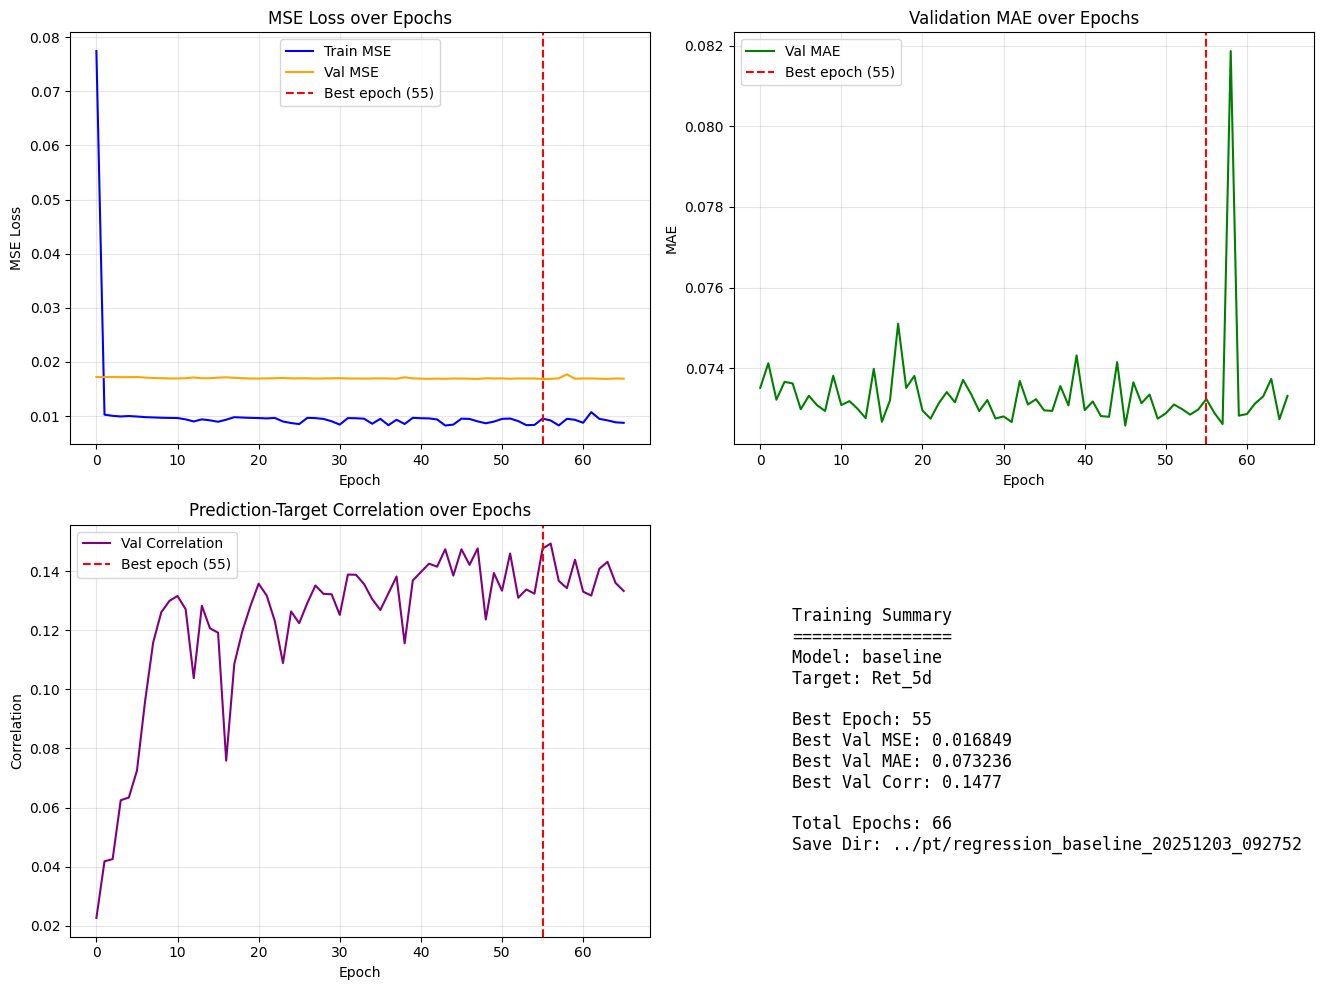


Training curves saved to: ../pt/regression_baseline_20251203_092752/training_curves.png


In [17]:
# 绘制训练曲线
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. MSE Loss
ax1 = axes[0, 0]
ax1.plot(history['train_loss'], label='Train MSE', color='blue')
ax1.plot(history['val_loss'], label='Val MSE', color='orange')
ax1.axvline(x=last_min_ind, color='red', linestyle='--', label=f'Best epoch ({last_min_ind})')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('MSE Loss')
ax1.set_title('MSE Loss over Epochs')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. MAE
ax2 = axes[0, 1]
ax2.plot(history['val_mae'], label='Val MAE', color='green')
ax2.axvline(x=last_min_ind, color='red', linestyle='--', label=f'Best epoch ({last_min_ind})')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('MAE')
ax2.set_title('Validation MAE over Epochs')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Correlation
ax3 = axes[1, 0]
ax3.plot(history['val_corr'], label='Val Correlation', color='purple')
ax3.axvline(x=last_min_ind, color='red', linestyle='--', label=f'Best epoch ({last_min_ind})')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Correlation')
ax3.set_title('Prediction-Target Correlation over Epochs')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Summary
ax4 = axes[1, 1]
ax4.axis('off')
summary_text = f"""
Training Summary
================
Model: {model_type}
Target: {target_col}

Best Epoch: {last_min_ind}
Best Val MSE: {min_val_loss:.6f}
Best Val MAE: {history['val_mae'][last_min_ind]:.6f}
Best Val Corr: {history['val_corr'][last_min_ind]:.4f}

Total Epochs: {len(history['train_loss'])}
Save Dir: {save_dir}
"""
ax4.text(0.1, 0.5, summary_text, fontsize=12, family='monospace', 
         verticalalignment='center', transform=ax4.transAxes)

plt.tight_layout()
plt.savefig(f'{save_dir}/training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nTraining curves saved to: {save_dir}/training_curves.png")
